In [250]:
import torch
from torch import nn
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

print(torch.__version__)

2.1.2+cu118


### DEVICE SETUP

Create device agnostic code 

This means if we got access to a GPU, our code will use it (for potentially faster computing)

If no GPU is available the code will run on CPU

In [251]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device: {device}')
!nvidia-smi

using device: cuda
Sun Jan 28 21:53:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.26                 Driver Version: 546.26       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8               9W /  95W |    260MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

### DATA SETUP

In [252]:
# Create some data using the linear regression formula of y = weight *x + bias 
weight = 0.7 
bias = 0.3 

# Create range values 
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = X*weight + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [253]:
# Train Split 
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test , y_test = X[train_split:] , y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [254]:
# Plot the data 
def plot_predictions(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test,predictions=None):
    """ Plots training data , test data and compare predictions """
    plt.figure(figsize=(10,7))
    
    # plot the training in blue 
    plt.scatter(train_data,train_labels,c='b',s=4,label='Training Data')
    
    # plot the test data in green 
    plt.scatter(test_data,test_labels,c='g',s=4,label='Testing Data')
    
    if predictions is not None:
        #* Plot the predictions if they exists 
        plt.scatter(test_data,predictions,c='r',s=4,label='Predictions')
        
    plt.legend(prop={"size":14})

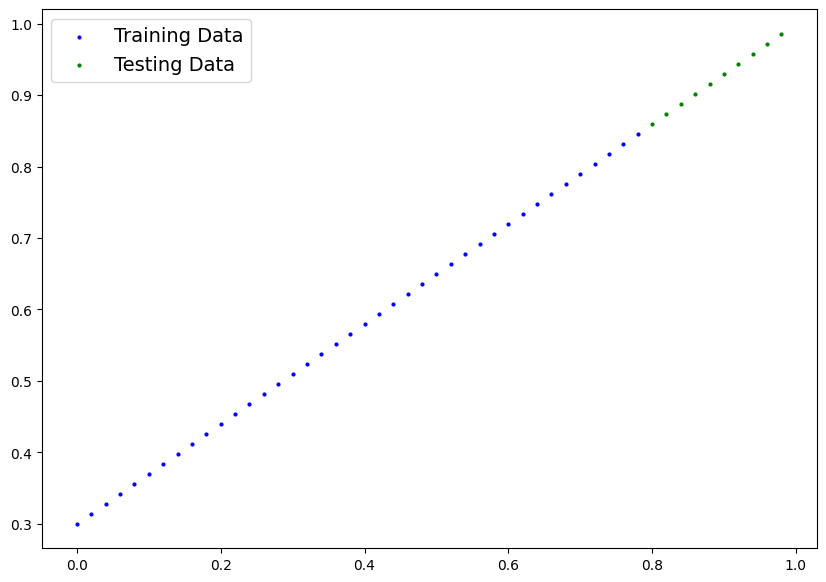

In [255]:
plot_predictions(X_train, y_train, X_test, y_test)

### Building the PyTorch Linear Model

In [256]:
class LinearRegressionModel(nn.Module):
    def __init__(self) :
        super().__init__()
        #* use nn.linear for creating the model parameters 
        #* also called:Linear Transform , Probing Layer , Fully Connected Layer , Dense Layer (in Tensorflow)
        self.liner_layer = nn.Linear(in_features=1,out_features=1)
        
    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.liner_layer(x)

#* Set the manual seed 
ANSWER_OF_UNIVERSE = 42
torch.manual_seed(ANSWER_OF_UNIVERSE)
model = LinearRegressionModel()
model, model.state_dict()

(LinearRegressionModel(
   (liner_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('liner_layer.weight', tensor([[0.7645]])),
              ('liner_layer.bias', tensor([0.8300]))]))

### Set the Target Device to the Model

In [257]:
device

'cuda'

In [258]:
model.to(device)

LinearRegressionModel(
  (liner_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [259]:
next(model.parameters()).device

device(type='cuda', index=0)

### Training Code

* For Training We Need
    * Loss Function 
    * Optimizer 
    * Trainig Loop 
    * Testing Loop

In [260]:
# Set up loss function 
loss_fn = nn.L1Loss()

# Set up our optimizer 
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)


In [261]:
%%time
# Training set-up 
torch.manual_seed(ANSWER_OF_UNIVERSE)

epoch_record = []
loss_record = []
test_loss_record = []

#* Put data on to target device 

model.to(device)

X_train =  X_train.to(device)
X_test = X_test.to(device)

y_train = y_train.to(device)
y_test =  y_test.to(device)

epochs = 150
for epoch in range(epochs):
    
    # swith model to train mode 
    model.train()
    
    # 1. Forward Pass 
    y_pred =  model.forward(X_train)
    
    # 2. Calculate loss 
    loss = loss_fn(y_pred,y_train)
    
    # 3. optimizer zero grad 
    optimizer.zero_grad()
    
    # 4. zero grad 
    loss.backward()
    
    # 5. optimizer step 
    optimizer.step()
    
    
    # 6. Testing the model ""
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred,y_test)
        
        epoch_record.append(epoch)
        loss_record.append(loss)
        test_loss_record.append(test_loss)
        
    if epoch % 10 == 0: 
        print(f'Epoch:{epoch}, | Loss:{loss} , test_loss:{test_loss} ')
        


Epoch:0, | Loss:0.5551779866218567 , test_loss:0.5739762187004089 
Epoch:10, | Loss:0.439968079328537 , test_loss:0.4392664134502411 
Epoch:20, | Loss:0.3247582018375397 , test_loss:0.30455657839775085 
Epoch:30, | Loss:0.20954833924770355 , test_loss:0.16984669864177704 
Epoch:40, | Loss:0.09433845430612564 , test_loss:0.03513690456748009 
Epoch:50, | Loss:0.023886388167738914 , test_loss:0.04784907028079033 
Epoch:60, | Loss:0.019956795498728752 , test_loss:0.045803118497133255 
Epoch:70, | Loss:0.016517987474799156 , test_loss:0.037530567497015 
Epoch:80, | Loss:0.013089174404740334 , test_loss:0.02994490973651409 
Epoch:90, | Loss:0.009653178043663502 , test_loss:0.02167237363755703 
Epoch:100, | Loss:0.006215683650225401 , test_loss:0.014086711220443249 
Epoch:110, | Loss:0.00278724217787385 , test_loss:0.005814164876937866 
Epoch:120, | Loss:0.0012645035749301314 , test_loss:0.013801801018416882 
Epoch:130, | Loss:0.0012645035749301314 , test_loss:0.013801801018416882 
Epoch:140,

In [262]:
model.state_dict() , weight, bias

(OrderedDict([('liner_layer.weight', tensor([[0.6968]], device='cuda:0')),
              ('liner_layer.bias', tensor([0.3025], device='cuda:0'))]),
 0.7,
 0.3)

In [263]:
# epoch_record,loss_record,test_loss_record

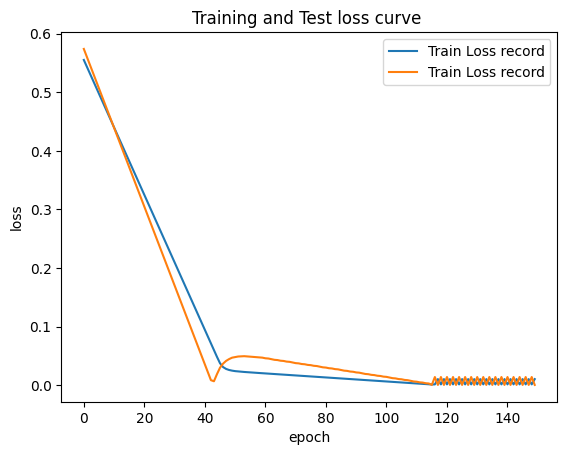

In [264]:
    
#* plot the progress of the our parameters 
plt.plot(epoch_record,torch.tensor(loss_record).to('cpu').numpy(),label='Train Loss record')
plt.plot(epoch_record,torch.tensor(test_loss_record).to('cpu').numpy(),label='Train Loss record')
plt.title('Training and Test loss curve ')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

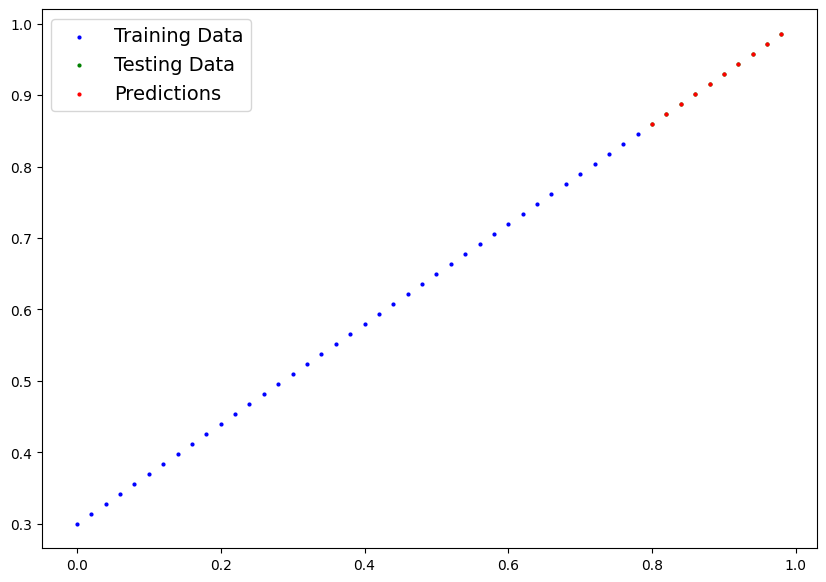

In [265]:
model.eval()
with torch.inference_mode():
    y_pred = model(X_test)


plot_predictions(predictions= (y_pred.cpu()))

### Saving the model 

In [266]:
from pathlib import Path

#* Create model directory 
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

#* Create model saved path 
MODEL_NAME = '01_paytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME


#* save the model dict instead of hole model 
print(f'the model state is saving to {MODEL_SAVE_PATH}')
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)

the model state is saving to models\01_paytorch_workflow_model_1.pth


### Loading the model

In [267]:
# Create a model 
model_saved = LinearRegressionModel()

In [268]:
model_saved.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_saved.to(device)
model_saved.state_dict()

OrderedDict([('liner_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('liner_layer.bias', tensor([0.3025], device='cuda:0'))])

In [269]:
next(model_saved.parameters()).device, next(model.parameters()).device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [270]:
model_saved.eval()
with torch.inference_mode():
    test = model_saved(X_test)

test == y_pred


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')